In [219]:
import pandas as pd
import gym
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings("ignore")

In [220]:
df = pd.read_csv('./crypto_data.csv')

In [221]:
df.head()

date     symbol    open    high     low   close  \
0  2020-12-25 05:00:00  1INCHUSDT  0.2000  3.0885  0.2000  2.5826   
1  2020-12-25 06:00:00  1INCHUSDT  2.5824  2.6900  2.2249  2.5059   
2  2020-12-25 07:00:00  1INCHUSDT  2.5152  2.8870  2.3609  2.6237   
3  2020-12-25 08:00:00  1INCHUSDT  2.6318  2.8247  2.4650  2.6134   
4  2020-12-25 09:00:00  1INCHUSDT  2.6104  2.7498  2.5629  2.6365   

   volume usdt  tradecount  token  hour     day  
0     35530516       48768  1INCH     5  Friday  
1     22440875       31099  1INCH     6  Friday  
2     21300426       33001  1INCH     7  Friday  
3     17491813       30459  1INCH     8  Friday  
4      9919400       21023  1INCH     9  Friday

In [222]:
df.columns

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume usdt',
       'tradecount', 'token', 'hour', 'day'],
      dtype='object')

In [223]:
start_date = '2020-08-17 04:00:00'
end_date = '2023-10-19 23:00:00'

In [224]:
data_df = df.copy(deep=True)

In [225]:
data_df = data_df[(data_df['token'] == 'BTC') & (data_df['date'] >= start_date) & (data_df['date'] <= end_date)]

In [226]:
data_df.columns

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume usdt',
       'tradecount', 'token', 'hour', 'day'],
      dtype='object')

### Mapping 'day' days to numerical values

In [227]:
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

data_df['day'] = data_df['day'].apply(lambda x: day_mapping[x])

### Creating new columns EMAs (EMA 13 25 32 100 200)

In [228]:
data_df['ema_13'] = data_df['close'].ewm(span=13).mean()
data_df['ema_25'] = data_df['close'].ewm(span=25).mean()
data_df['ema_32'] = data_df['close'].ewm(span=32).mean()
data_df['ema_100'] = data_df['close'].ewm(span=100).mean()
data_df['ema_200'] = data_df['close'].ewm(span=200).mean()

### Creating Candle Volatility Against Price Close (high - low / close)

In [229]:
data_df['vol_close'] = (data_df['high'] - data_df['low']) / data_df['close']

### Creating EMA for Candle Volatility/Price 

In [230]:
# EMA for 2 hours (candles)
data_df['vol_close_ema_3'] = data_df['vol_close'].ewm(span=3, adjust=False).mean()

# EMA for 4 hours (candles)
data_df['vol_close_ema_6'] = data_df['vol_close'].ewm(span=6, adjust=False).mean()

# EMA for 8 hours ((candles)
data_df['vol_close_ema_12'] = data_df['vol_close'].ewm(span=12, adjust=False).mean()

In [231]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27812 entries, 343607 to 371418
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              27812 non-null  object 
 1   symbol            27812 non-null  object 
 2   open              27812 non-null  float64
 3   high              27812 non-null  float64
 4   low               27812 non-null  float64
 5   close             27812 non-null  float64
 6   volume usdt       27812 non-null  int64  
 7   tradecount        27812 non-null  int64  
 8   token             27812 non-null  object 
 9   hour              27812 non-null  int64  
 10  day               27812 non-null  int64  
 11  ema_13            27812 non-null  float64
 12  ema_25            27812 non-null  float64
 13  ema_32            27812 non-null  float64
 14  ema_100           27812 non-null  float64
 15  ema_200           27812 non-null  float64
 16  vol_close         27812 non-null  float

In [232]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [233]:
columns_to_drop = ['symbol', 'token']
data_df = data_df.drop(columns=columns_to_drop)

In [234]:
#data_df = data_df.astype(float)
#data_df.set_index('date', inplace=True)

In [235]:
data_df.to_csv('data_featured.csv', index=False)

In [236]:
train_df = data_df.copy(deep=True)
train_df.reset_index(drop=True, inplace=True)

In [237]:
train_df.head()

date      open      high       low     close  volume usdt  \
0 2020-08-17 04:00:00  11844.72  11858.91  11802.35  11809.38     17196539   
1 2020-08-17 05:00:00  11809.39  11836.90  11790.00  11800.01     19958274   
2 2020-08-17 06:00:00  11800.00  11846.74  11785.23  11806.37     19327915   
3 2020-08-17 07:00:00  11806.37  11843.01  11792.32  11807.21     22698672   
4 2020-08-17 08:00:00  11806.94  11885.00  11806.91  11868.77     28031116   

   tradecount  hour  day        ema_13        ema_25        ema_32  \
0       28800     4    1  11809.380000  11809.380000  11809.380000   
1       28571     5    1  11804.334615  11804.507600  11804.548594   
2       29762     6    1  11805.119921  11805.178699  11805.194058   
3       33111     7    1  11805.768697  11805.749021  11805.746245   
4       37458     8    1  11822.518351  11820.447106  11819.974205   

        ema_100       ema_200  vol_close  vol_close_ema_3  vol_close_ema_6  \
0  11809.380000  11809.380000   0.004789         0.004789         0.004789   
1  11804.648150  11804.671575   0.003975         0.004382         0.004557   
2  11805.233617  11805.243387   0.005210         0.004796         0.004743   
3  11805.742633  11805.742440   0.004293         0.004545         0.004615   
4  11818.857316  11818.601316   0.006579         0.005562         0.005176   

   vol_close_ema_12  
0          0.004789  
1          0.004664  
2          0.004748  
3          0.004678  
4          0.004971

In [238]:
#df_test = data_df[10000:]
#df_test = df_test.reset_index(drop=True)

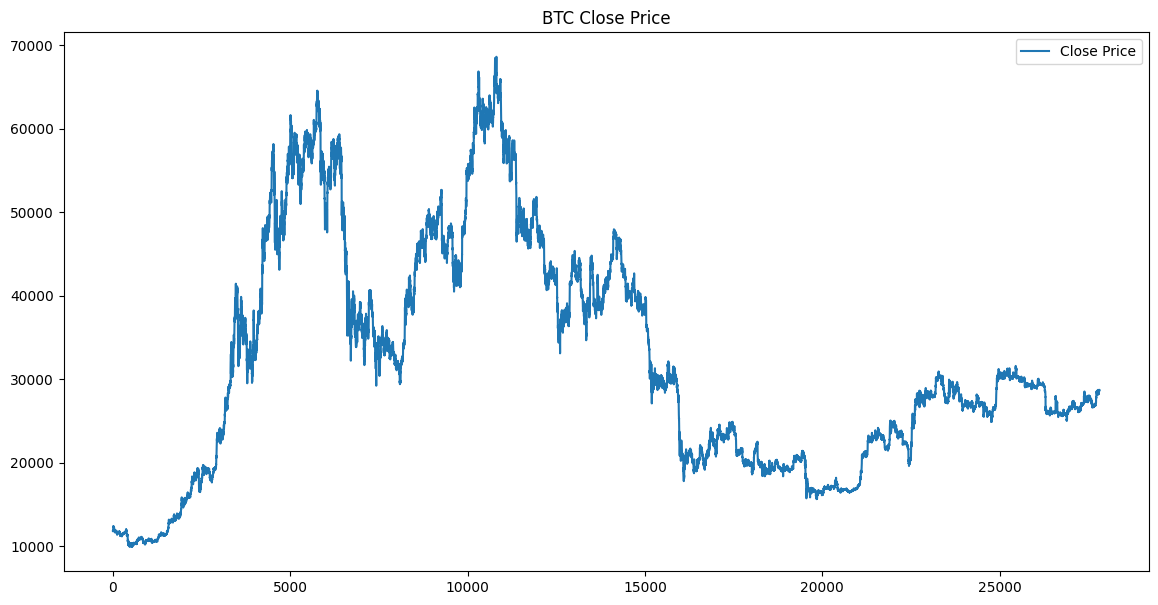

(27812, 18)

In [239]:
# show test data diagram

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_df['close'], label='Close Price')
plt.title('BTC Close Price')
plt.legend()
plt.show()

train_df.shape


## <span style="color:#5E6997"> DRL Environment Architecture </span> <a class="anchor" id="env"></a>

# DRL Environment v1

In [240]:
class CryptoTradingEnv(gym.Env):
    def __init__(self, data, take_profit_position_range=(0.10, 0.80), stop_loss_position_range=(0.00, 0.15), max_stop_loss_position=0.30):
        super(CryptoTradingEnv, self).__init__()
        
        self.data = data.reset_index(drop=True)

        self.data = data
        self.n_steps = len(data)
        self.current_step = 0
        self.initial_balance = 10000 
        self.balance = self.initial_balance
        self.position = 0
        self.position_open = 0 # Price at which the position was opened
        self.num_trades = 0  # Number of trades
        self.profit_loss = 0  # PnL Profit/Loss
        self.max_stop_loss_position = max_stop_loss_position 

        self.take_profit_position_range = take_profit_position_range
        self.stop_loss_position_range = stop_loss_position_range

        # 0=Hold, 1=Open Position, 2=Close Position
        self.action_space = gym.spaces.Discrete(3)

        # Observations
        n_features = 15 
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(n_features,))

        self.episode_returns = []  
        self.cumulative_returns = 0 
        self.winning_trades = 0  
        self.losing_trades = 0 
        self.hourly_returns = []
        
        self.overall_rewards = 0


    def step(self, action):
        if self.current_step >= self.n_steps - 1:
            return self.get_observation(), 0, True, {}
        
        self.current_step += 1
        done = False

        reward = 0
        trade_outcome = 0
        trade_within_range = False

        if action == 1:  # Open Position
            if self.position == 0:  # Only open a position if not already in a trade
                print("👉 Opening trade...")
                
                reward += 0.1
                
                position_size = 0.05 * self.balance
                self.position_open = self.data.loc[self.current_step, 'open']
                self.position = 1
                self.num_trades += 1
                
                
                print(f"Opened trade at step {self.current_step} with position size: {position_size:.2f}")
        elif action == 2:  # Close Position
            if self.position == 1:  # Only close a position if currently in a trade
                print("👉 Closing trade...")
                reward += 0.1
                
                position_close = self.data.loc[self.current_step, 'open']
                trade_outcome = position_close - self.position_open
                self.profit_loss += trade_outcome
                self.position = 0
                self.position_open = 0
                print(f"Closed trade at step {self.current_step}")
                print(f"------------------------------> Trade outcome: {trade_outcome}")

                self.balance += trade_outcome
                
                # Check for take profit and stop loss
                if trade_outcome > 0:
                    if trade_outcome >= self.take_profit_position_range[0] * self.position:
                        reward = 1  # Trade reached take profit
                        self.winning_trades += 1  # +1 winning trades count
                        if trade_outcome <= self.take_profit_position_range[1] * self.position and trade_outcome >= self.take_profit_position_range[0] * self.position:
                           # self.trade_within_range = True
                            print("Trade reached take profit")
                elif trade_outcome < 0:
                    if abs(trade_outcome) >= self.max_stop_loss_position * self.position:
                        reward = -1.7  # Trade reached the maximum stop loss
                        self.losing_trades += 1  # +1 losing trades count
                        print("Trade reached the maximum stop loss")
                    elif abs(trade_outcome) >= self.stop_loss_position_range[0] * self.position:
                        reward = -1  # Trade reached the stop loss
                        self.losing_trades += 1  # +1 losing trades count
                        print("Trade reached stop loss")
                    else:
                        # No reward (positive and negative) if the trade closed with no loss
                        reward = 0
                        print("Trade closed with no loss")

#                if trade_within_range:
#                    self.winning_trade_within_range += 1

    # reward based on profit/loss of the last trade
#        reward += trade_outcome
        if trade_outcome > 0:
            reward += 0.5
        print(f"Reward: {reward}")

        # reward for this episode
        self.episode_returns.append(reward)

        # cumulative returns
        self.cumulative_returns += reward

        # hourly returns for daily return calculation
#        self.hourly_returns.append(reward)

        self.overall_rewards += reward  

        if self.current_step >= self.n_steps:
            done = True

        next_state = self.get_observation()
        return next_state, reward, done, {}


    def reset(self):
        self.current_step = 0
        self.position = 0
        self.position_open = 0
        episode_return = np.sum(self.episode_returns)
        self.episode_returns = []
        self.cumulative_returns += episode_return
        self.current_week_start = 0
        return self.get_observation()

    def render(self, mode='human'):
        if mode == 'human':
            print(f"Step: {self.current_step}")
            print(f"Open Position: {self.position}")
            print(f"Trades: {self.num_trades} | Profit/Loss: {self.profit_loss:.2f}")
            print(f"Balance: {self.balance:.2f}")
            print(f"Winning Trades: {self.winning_trades} | Losing Trades: {self.losing_trades}")
            print(f"Overall Rewards: {self.overall_rewards:.2f}")

    def close(self):
        pass

    def get_observation(self):
        if self.current_step >= len(self.data):
            self.current_step = len(self.data) - 1
            
        obs = self.data.loc[self.current_step, [
            'open', 'high', 'low', 'close', 'volume usdt', 'hour', 'day',
            'ema_13', 'ema_25', 'ema_32', 'ema_100', 'ema_200', 'vol_close_ema_3', 'vol_close_ema_6', 'vol_close_ema_12'
        ]].values.astype(np.float32)
        return obs / obs.max()


## <span style="color:#5E6997"> DRL Agent Architecture </span> <a class="anchor" id="agent"></a>

# DRL Agent v1

In [241]:
num_episodes = 5000
print_interval = 100

# split train and test data
# train_data = train_df.iloc[:int(0.8 * len(train_df))]
# test_data = train_df.iloc[int(0.8 * len(train_df)):]

train_size = int(0.8 * len(train_df))
train_data = train_df.iloc[:train_size].reset_index(drop=True)
test_data = train_df.iloc[train_size:].reset_index(drop=True)

test_data.reset_index(drop=True, inplace=True)

# env = CryptoTradingEnv(train_data)
env = DummyVecEnv([lambda: CryptoTradingEnv(train_data)])

# obs = env.reset()

agent = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    # learning_rate=3e-4,   # Học chậm để tránh overfitting
    batch_size=64,        # Cỡ batch phù hợp
    gamma=0.99,           # Discount factor để ưu tiên phần thưởng dài hạn
    ent_coef=0.01,        # Thêm entropy để tăng khám phá
    n_steps=2048,         # Giảm cập nhật quá thường xuyên
    clip_range=0.2        # Giữ PPO clipping ổn định
)

# 🚀 Train mô hình
agent.learn(total_timesteps=25000)

# agent = PPO("MlpPolicy", DummyVecEnv([lambda: env]), verbose=1)
# 
# max_steps = 50000 # I was getting error for out of index so i limited the max step
# 
# for episode in range(num_episodes):
#     obs = np.array(obs, dtype=np.float32)
#     action, _ = agent.predict(obs, deterministic=False)
# 
#     remaining_steps = min(max_steps - env.current_step, env.n_steps)
# 
#     if remaining_steps > 0:
#         obs, reward, done, _ = env.step(action)
#         env.render()
# 
# # #    if done:
# # #        obs = env.reset()
# 
#     if (episode + 1) % print_interval == 0:
#         print(f"Episode {episode + 1}: Final Rewards: {env.cumulative_returns:.2f} | Total Trades: {env.num_trades}")

Using cpu device
Reward: 0
👉 Opening trade...
Opened trade at step 2 with position size: 500.00
Reward: 0.1
👉 Closing trade...
Closed trade at step 3
------------------------------> Trade outcome: 6.3700000000008
Reward: 1.5
👉 Opening trade...
Opened trade at step 4 with position size: 500.32
Reward: 0.1
Reward: 0
Reward: 0
👉 Closing trade...
Closed trade at step 7
------------------------------> Trade outcome: 53.88999999999942
Reward: 1.5
Reward: 0
👉 Opening trade...
Opened trade at step 9 with position size: 503.01
Reward: 0.1
Reward: 0
👉 Closing trade...
Closed trade at step 11
------------------------------> Trade outcome: 284.2000000000007
Reward: 1.5
Reward: 0
Reward: 0
👉 Opening trade...
Opened trade at step 14 with position size: 517.22
Reward: 0.1
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
👉 Closing trade...
Closed trade at step 20
------------------------------> Trade outcome: -84.27000000000044
Trade reached the maximum stop loss
Reward: -1.7
Reward: 0
👉 Opening trad

### Save configuration

In [242]:
(train_df.shape,train_data.shape,test_data.shape)

((27812, 18), (22249, 18), (5563, 18))

In [243]:
agent.save('v1_ppodrl')

## DQN

In [244]:
# env = CryptoTradingEnv(train_data)
env = DummyVecEnv([lambda: CryptoTradingEnv(train_data)])

obs = env.reset()

agentDQN = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    exploration_fraction=0.1,  # 10% thời gian đầu sẽ khám phá nhiều hơn
    exploration_final_eps=0.01,  # Khi training gần xong, vẫn có 1% cơ hội khám phá
    # learning_rate=1e-3,
    buffer_size=100000,  # Replay buffer lớn để tránh overfitting
    batch_size=32,
    train_freq=4,  # Cập nhật mô hình mỗi 4 bước
    target_update_interval=1000,  # Cập nhật Q-target sau mỗi 1000 bước
)

# 🚀 Train model
agentDQN.learn(total_timesteps=25000)

# agentDQN = DQN("MlpPolicy", DummyVecEnv([lambda: env]), verbose=1)
# 
# max_steps = 50000 # I was getting error for out of index so i limited the max step
# 
# for episode in range(num_episodes):
#     obs = np.array(obs, dtype=np.float32)
#     action, _ = agentDQN.predict(obs, deterministic=False)
# 
#     remaining_steps = min(max_steps - env.current_step, env.n_steps)
# 
#     if remaining_steps > 0:
#         obs, reward, done, _ = env.step(action)
#         env.render()
# 
# # #    if done:
# # #        obs = env.reset()
# 
#     if (episode + 1) % print_interval == 0:
#         print(f"Episode {episode + 1}: Final Rewards: {env.cumulative_returns:.2f} | Total Trades: {env.num_trades}")

Using cpu device
Reward: 0
👉 Opening trade...
Opened trade at step 2 with position size: 500.00
Reward: 0.1
👉 Closing trade...
Closed trade at step 3
------------------------------> Trade outcome: 6.3700000000008
Reward: 1.5
Reward: 0
👉 Opening trade...
Opened trade at step 5 with position size: 500.32
Reward: 0.1
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
👉 Closing trade...
Closed trade at step 12
------------------------------> Trade outcome: 552.8700000000008
Reward: 1.5
Reward: 0
👉 Opening trade...
Opened trade at step 14 with position size: 527.96
Reward: 0.1
👉 Closing trade...
Closed trade at step 15
------------------------------> Trade outcome: -58.780000000000655
Trade reached the maximum stop loss
Reward: -1.7
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
Reward: 0
👉 Opening trade...
Opened trade at step 27 with position size: 525.02
Reward: 0.1
Reward: 0
👉 Closing trade...
Closed trade at step 29
--------

In [245]:
agentDQN.save('v1_DQNdrl')

## A2C

In [246]:
# env = CryptoTradingEnv(train_data)
env = DummyVecEnv([lambda: CryptoTradingEnv(train_data)])

obs = env.reset()

# agentA2C = A2C("MlpPolicy", DummyVecEnv([lambda: env]), verbose=1)

agentA2C = A2C(
    "MlpPolicy",
    env,
    verbose=1,
    # learning_rate=1e-3,
    n_steps=5,  # Giảm số bước trước khi cập nhật để phản ứng nhanh hơn với thị trường
    gamma=0.99,  # Discount factor
    ent_coef=0.01,  # Thêm entropy để tăng khả năng khám phá
)

# 🚀 Train model
agentA2C.learn(total_timesteps=25000)

# max_steps = 50000 # I was getting error for out of index so i limited the max step
# 
# for episode in range(num_episodes):
#     obs = np.array(obs, dtype=np.float32)
#     action, _ = agentA2C.predict(obs, deterministic=False)
# 
#     remaining_steps = min(max_steps - env.current_step, env.n_steps)
# 
#     if remaining_steps > 0:
#         obs, reward, done, _ = env.step(action)
#         env.render()
# 
# # #    if done:
# # #        obs = env.reset()
# 
#     if (episode + 1) % print_interval == 0:
#         print(f"Episode {episode + 1}: Final Rewards: {env.cumulative_returns:.2f} | Total Trades: {env.num_trades}")

Using cpu device
Reward: 0
Reward: 0
Reward: 0
👉 Opening trade...
Opened trade at step 4 with position size: 500.00
Reward: 0.1
Reward: 0
👉 Closing trade...
Closed trade at step 6
------------------------------> Trade outcome: 49.36999999999898
Reward: 1.5
Reward: 0
Reward: 0
👉 Opening trade...
Opened trade at step 9 with position size: 502.47
Reward: 0.1
Reward: 0
👉 Closing trade...
Closed trade at step 11
------------------------------> Trade outcome: 284.2000000000007
Reward: 1.5
Reward: 0
Reward: 0
👉 Opening trade...
Opened trade at step 14 with position size: 516.68
Reward: 0.1
👉 Closing trade...
Closed trade at step 15
------------------------------> Trade outcome: -58.780000000000655
Trade reached the maximum stop loss
Reward: -1.7
Reward: 0
Reward: 0
Reward: 0
Reward: 0
👉 Opening trade...
Opened trade at step 20 with position size: 513.74
Reward: 0.1
Reward: 0
👉 Closing trade...
Closed trade at step 22
------------------------------> Trade outcome: 46.18000000000029
Reward: 1.5

In [247]:
agentA2C.save('v1_A2Cdrl')

# Test Validation Phase

### Import / load validation data

In [248]:
val_data = train_df

In [249]:
val_data = val_data.reset_index(drop=True)

In [250]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27812 entries, 0 to 27811
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              27812 non-null  datetime64[ns]
 1   open              27812 non-null  float64       
 2   high              27812 non-null  float64       
 3   low               27812 non-null  float64       
 4   close             27812 non-null  float64       
 5   volume usdt       27812 non-null  int64         
 6   tradecount        27812 non-null  int64         
 7   hour              27812 non-null  int64         
 8   day               27812 non-null  int64         
 9   ema_13            27812 non-null  float64       
 10  ema_25            27812 non-null  float64       
 11  ema_32            27812 non-null  float64       
 12  ema_100           27812 non-null  float64       
 13  ema_200           27812 non-null  float64       
 14  vol_close         2781

In [251]:
val_data.head()

date      open      high       low     close  volume usdt  \
0 2020-08-17 04:00:00  11844.72  11858.91  11802.35  11809.38     17196539   
1 2020-08-17 05:00:00  11809.39  11836.90  11790.00  11800.01     19958274   
2 2020-08-17 06:00:00  11800.00  11846.74  11785.23  11806.37     19327915   
3 2020-08-17 07:00:00  11806.37  11843.01  11792.32  11807.21     22698672   
4 2020-08-17 08:00:00  11806.94  11885.00  11806.91  11868.77     28031116   

   tradecount  hour  day        ema_13        ema_25        ema_32  \
0       28800     4    1  11809.380000  11809.380000  11809.380000   
1       28571     5    1  11804.334615  11804.507600  11804.548594   
2       29762     6    1  11805.119921  11805.178699  11805.194058   
3       33111     7    1  11805.768697  11805.749021  11805.746245   
4       37458     8    1  11822.518351  11820.447106  11819.974205   

        ema_100       ema_200  vol_close  vol_close_ema_3  vol_close_ema_6  \
0  11809.380000  11809.380000   0.004789         0.004789         0.004789   
1  11804.648150  11804.671575   0.003975         0.004382         0.004557   
2  11805.233617  11805.243387   0.005210         0.004796         0.004743   
3  11805.742633  11805.742440   0.004293         0.004545         0.004615   
4  11818.857316  11818.601316   0.006579         0.005562         0.005176   

   vol_close_ema_12  
0          0.004789  
1          0.004664  
2          0.004748  
3          0.004678  
4          0.004971

In [252]:
pre_trained_PPOagent = PPO.load('v1_ppodrl')
pre_trained_DQNagent = DQN.load('v1_DQNdrl')
pre_trained_A2Cagent = A2C.load('v1_A2Cdrl')

In [253]:
max_steps = 25000

In [254]:
env_test = CryptoTradingEnv(test_data)
obs = env_test.reset()

obs = env_test.get_observation()
print(f"Observation: {obs}")

num_episodes = 1000

for episode in range(num_episodes):
    obs = np.array(obs, dtype=np.float32)
    action, _ = pre_trained_PPOagent.predict(obs, deterministic=False) 
    print(f"Predicted Action: {action}")
    obs, reward, done, _ = env_test.step(action)
    env_test.render()

    remaining_steps = min(max_steps - env_test.current_step, env_test.n_steps)

    if remaining_steps > 0:
        obs, reward, done, _ = env_test.step(action)
        env_test.render()

    if (episode + 1) % 1000 == 0:
        print(f"Episode {episode + 1}: Final Rewards: {env_test.cumulative_returns:.2f} | Total Trades: {env_test.num_trades}")

Observation: [1.5871407e-04 1.5877085e-04 1.5786651e-04 1.5810294e-04 1.0000000e+00
 3.3716812e-08 2.6973451e-08 1.5873564e-04 1.5880083e-04 1.5875364e-04
 1.5848258e-04 1.5892215e-04 3.3157834e-11 3.6176149e-11 4.1472794e-11]
Predicted Action: 1
👉 Opening trade...
Opened trade at step 1 with position size: 500.00
Reward: 0.1
Step: 1
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Reward: 0
Step: 2
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Predicted Action: 0
Reward: 0
Step: 3
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Reward: 0
Step: 4
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Predicted Action: 1
Reward: 0
Step: 5
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 

In [255]:
env_test = CryptoTradingEnv(test_data)
obs = env_test.reset()

num_episodes = 1000

for episode in range(num_episodes):
    obs = np.array(obs, dtype=np.float32)
    action, _ = pre_trained_DQNagent.predict(obs, deterministic=False) 
    print(f"Predicted Action: {action}")
    obs, reward, done, _ = env_test.step(action)
    env_test.render()

    remaining_steps = min(max_steps - env_test.current_step, env_test.n_steps)

    if remaining_steps > 0:
        obs, reward, done, _ = env_test.step(action)
        env_test.render()

    if (episode + 1) % 1000 == 0:
        print(f"Episode {episode + 1}: Final Rewards: {env_test.cumulative_returns:.2f} | Total Trades: {env_test.num_trades}")

Predicted Action: 2
Reward: 0
Step: 1
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Reward: 0
Step: 2
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Predicted Action: 2
Reward: 0
Step: 3
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Reward: 0
Step: 4
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Predicted Action: 2
Reward: 0
Step: 5
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Reward: 0
Step: 6
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Predicted Action: 2
Reward: 0
Step: 7
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Bal

In [256]:
env_test = CryptoTradingEnv(test_data)
obs = env_test.reset()

num_episodes = 1000

for episode in range(num_episodes):
    obs = np.array(obs, dtype=np.float32)
    action, _ = pre_trained_A2Cagent.predict(obs, deterministic=False) 
    print(f"Predicted Action: {action}")
    obs, reward, done, _ = env_test.step(action)
    env_test.render()

    remaining_steps = min(max_steps - env_test.current_step, env_test.n_steps)

    if remaining_steps > 0:
        obs, reward, done, _ = env_test.step(action)
        env_test.render()

    if (episode + 1) % 1000 == 0:
        print(f"Episode {episode + 1}: Final Rewards: {env_test.cumulative_returns:.2f} | Total Trades: {env_test.num_trades}")

Predicted Action: 0
Reward: 0
Step: 1
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Reward: 0
Step: 2
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
Predicted Action: 1
👉 Opening trade...
Opened trade at step 3 with position size: 500.00
Reward: 0.1
Step: 3
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Reward: 0
Step: 4
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Predicted Action: 1
Reward: 0
Step: 5
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Reward: 0
Step: 6
Open Position: 1
Trades: 1 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.10
Predicted Action:

For 25k: 
- PPO: Balance: 16204.96 | Winning Trades: 77 | Losing Trades: 97 | Overall Rewards: -31.90 | Final Rewards: -31.90 | Total Trades: 175
- DQN: Balance: 9292.84 | Winning Trades: 2 | Losing Trades: 2 | Overall Rewards: 0.00 | Final Rewards: 0.00 | Total Trades: 4
- A2C: Balance: 7074.64 | Winning Trades: 79 | Losing Trades: 90 | Overall Rewards: -17.50 | Final Rewards: -17.50 | Total Trades: 170

For 15k:
- PPO: Balance: 16872.11 | Winning Trades: 95 | Losing Trades: 73 | Overall Rewards: 35.20 | Final Rewards: 35.20 | Total Trades: 168
- DQN: Balance: 10639.07 | Winning Trades: 2 | Losing Trades: 4 | Overall Rewards: -3.20 | Final Rewards: -3.20 | Total Trades: 6
- A2C: Balance: 3957.84 | Winning Trades: 117 | Losing Trades: 140 | Overall Rewards: -36.70 | Final Rewards: -36.70 | Total Trades: 258

For 5k:
- PPO: Balance: 10062.36 | Winning Trades: 72 | Losing Trades: 57 | Overall Rewards: 24.00 | Final Rewards: 24.00 | Total Trades: 129
- DQN: Balance: 10334.10 | Winning Trades: 3 | Losing Trades: 0 | Overall Rewards: 4.80 | Final Rewards: 4.80 | Total Trades: 3
- A2C: Balance: 10941.32 | Winning Trades: 101 | Losing Trades: 108 | Overall Rewards: -11.20 | Final Rewards: -11.20 | Total Trades: 209

In [257]:
# show test data diagram

# import matplotlib.pyplot as plt
# 
# plt.figure(figsize=(14, 7))
# plt.plot(test_data['close'], label='Close Price')
# plt.title('BTC Close Price')
# plt.legend()
# plt.show()


### Thank you for taking the time to go through my notebook